In [1]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Any, Tuple
import pickle
import torch
from utilsHannes import mean_pointwise_l2_distance


/opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# ## Functions

# def get_sorted_most_likely_trajectories(logits: np.ndarray, lattice: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    
#     softmax = torch.nn.Softmax(dim=1)
#     probabilities = softmax(torch.Tensor(logits))
#     sortedProbabilitiesIndices = np.flip(np.array(np.argsort(probabilities, axis=-1))).copy()
#     sortedProbabilities = np.array(np.take_along_axis(probabilities, sortedProbabilitiesIndices, axis=-1))
#     sortedTrajectories = lattice[sortedProbabilitiesIndices]
    
#     return [sortedProbabilities, sortedTrajectories]


# def get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_trajectories, k_nr_of_trajectories) -> Tuple[np.array, np.array]:
    
#     top_k_trajectories = sorted_predicted_trajectories[:,:k_nr_of_trajectories,:,:]
    
#     n_epochs = num_epochs # TODO, automate
#     n_datapoints_per_epoch = 512 # TODO, automate
    
#     ave_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
#     min_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
#     count = 0
#     # Loop over epochs
#     for e in range(n_epochs):
        
#         # Loop over datapoints
#         for d in range(n_datapoints_per_epoch):
#             tmp_ADE = 1e10
#             min_ADE[d,e] = tmp_ADE
#             # Loop over each trajectory
#             for k in range(k_nr_of_trajectories):
#                 tmp_ADE = np.mean(np.linalg.norm(top_k_trajectories[count,k,:,:] - ground_truth_trajectories[count,:,:], axis=-1))
# #                 print(f"tmp_ADE = {tmp_ADE}")
#                 ave_ADE[d,e] += tmp_ADE/k_nr_of_trajectories
#                 if tmp_ADE < min_ADE[d,e]:
#                     min_ADE[d,e] = tmp_ADE
#             count += 1
            
#     return [np.mean(min_ADE, axis=0), np.mean(ave_ADE, axis=0)]


In [3]:
## Load data

# epochs = [50,51,52,53,54,55,56,57]
# legend_list = ['250*250','125*125','50*50','10*10','2*2','1*1','50*50 + covernet input','125*125 + covernet input']

# epochs = [299,301]
# legend_list = ['10*10 (299e)','500*500 (301e)']

# epochs = [499]
# legend_list = ['125*125 (569e)']
# num_epochs = 569

epochs = [500]
legend_list = ['10*10 (500e)']

num_epochs = min(epochs)
num_epochs = 420

# Files
file_path_list = [f"tmpResults/results_epochs={epoch}" for epoch in epochs]
num_files = len(file_path_list)

# Settings
file_number = 0
train_boolean = 'no'

# Load the .npy files
if train_boolean == 'yes':
    logits_loaded_list = [(np.load(f'{file_path}_train_logits.npy'))[:num_epochs*512] for file_path in file_path_list]
    ground_truth_loaded_list = [(np.load(f'{file_path}_train_ground_truth.npy'))[:num_epochs*512] for file_path in file_path_list]
elif train_boolean == 'no':
    logits_loaded_list = [(np.load(f'{file_path}_val_logits.npy'))[:num_epochs*512] for file_path in file_path_list]
    ground_truth_loaded_list = [(np.load(f'{file_path}_val_ground_truth.npy'))[:num_epochs*512] for file_path in file_path_list]
else:
    logits_loaded_list = [(np.load(f'{file_path}_logits.npy'))[:num_epochs*512] for file_path in file_path_list]
    ground_truth_loaded_list = [(np.load(f'{file_path}_ground_truth.npy'))[:num_epochs*512] for file_path in file_path_list]
    
softmaxy = torch.nn.Softmax(dim=1)
probabilities_list = [softmaxy(torch.Tensor(logits)).detach().numpy().squeeze() for logits in logits_loaded_list]


# Print the data
print(f"len(logits_loaded_list) = {len(logits_loaded_list)}")
print(f"len(ground_truth_loaded_list) = {len(ground_truth_loaded_list)}")
print(f"logits_loaded_list[{file_number}].shape = {logits_loaded_list[file_number].shape}")
print(f"probabilities_list[{file_number}].shape = {probabilities_list[file_number].shape}")
print(f"ground_truth_loaded_list[{file_number}].shape = {ground_truth_loaded_list[file_number].shape}")

# Load lattice
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    trajectories = pickle.load(f)
lattice = np.array(trajectories)
                                

len(logits_loaded_list) = 1
len(ground_truth_loaded_list) = 1
logits_loaded_list[0].shape = (215040, 64)
probabilities_list[0].shape = (215040, 64)
ground_truth_loaded_list[0].shape = (215040, 12, 2)


In [4]:
## Functions

def get_sorted_most_likely_trajectories(logits: np.ndarray, lattice: np.ndarray): # -> Tuple[np.ndarray, np.ndarray]:
    
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(torch.Tensor(logits))
    sortedProbabilitiesIndices = np.flip(np.array(np.argsort(probabilities, axis=-1)), axis=-1).copy()
    sortedProbabilities = np.array(np.take_along_axis(probabilities, sortedProbabilitiesIndices, axis=-1))
    sortedTrajectories = lattice[sortedProbabilitiesIndices]
    
    return sortedProbabilities, sortedTrajectories


def get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_trajectories, k_nr_of_trajectories): # -> Tuple[np.array, np.array]:
    
    top_k_trajectories = sorted_predicted_trajectories[:,:k_nr_of_trajectories,:,:]
    
    n_epochs = num_epochs # TODO, automate
    n_datapoints_per_epoch = 512 # TODO, automate
    
    ave_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    min_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    count = 0
    # Loop over epochs
    for e in range(n_epochs):
        
        # Loop over datapoints
        for d in range(n_datapoints_per_epoch):
            tmp_ADE = 1e10
            min_ADE[d,e] = tmp_ADE
            # Loop over each trajectory
            for k in range(k_nr_of_trajectories):
                tmp_ADE = np.mean(np.linalg.norm(top_k_trajectories[count,k,:,:] - ground_truth_trajectories[count,:,:], axis=-1))
                ave_ADE[d,e] += tmp_ADE/k_nr_of_trajectories
                if tmp_ADE < min_ADE[d,e]:
                    min_ADE[d,e] = tmp_ADE
            count += 1
            
    return np.mean(min_ADE, axis=0), np.mean(ave_ADE, axis=0)


len(sorted_predicted_probabilities_list) = 1
len(sorted_predicted_trajectories_list) = 1
sorted_predicted_probabilities_list[0].shape = (215040, 64)
sorted_predicted_trajectories_list[0].shape = (215040, 64, 12, 2)

min_ADE_list[0].shape = (420,)

ave_ADE_list[0].shape = (420,)

min_ADE_list[0][-1] = 2.8284288425824493

ave_ADE_list[0][-1] = 7.7464576605140865


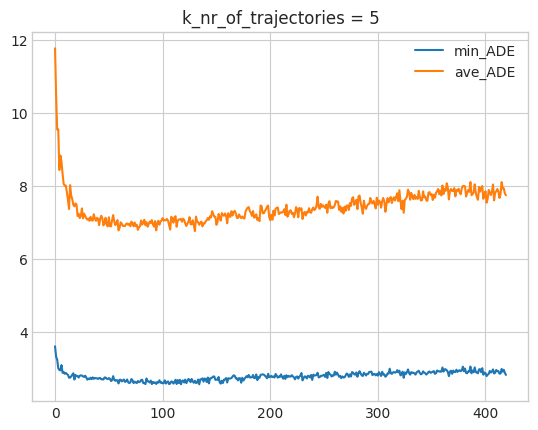

In [5]:
############### Calculate and plot many files

k_nr_of_trajectories = 5

results1 = [get_sorted_most_likely_trajectories(logits_loaded, lattice) for logits_loaded in logits_loaded_list]
sorted_predicted_probabilities_list, sorted_predicted_trajectories_list = zip(*results1)

results2 = [get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_loaded, k_nr_of_trajectories) for sorted_predicted_trajectories, ground_truth_loaded in zip(sorted_predicted_trajectories_list, ground_truth_loaded_list)]
min_ADE_list, ave_ADE_list = zip(*results2)

print(f"len(sorted_predicted_probabilities_list) = {len(sorted_predicted_probabilities_list)}")
print(f"len(sorted_predicted_trajectories_list) = {len(sorted_predicted_trajectories_list)}")
print(f"sorted_predicted_probabilities_list[{file_number}].shape = {sorted_predicted_probabilities_list[file_number].shape}")
print(f"sorted_predicted_trajectories_list[{file_number}].shape = {sorted_predicted_trajectories_list[file_number].shape}")
# print(f"sortedTrajectories = {sorted_predicted_trajectories_list[0][2]}") # [0][0/1] and [0][2/3] the same

print(f"\nmin_ADE_list[{file_number}].shape = {min_ADE_list[file_number].shape}")
print(f"\nave_ADE_list[{file_number}].shape = {ave_ADE_list[file_number].shape}")
print(f"\nmin_ADE_list[{file_number}][-1] = {min_ADE_list[file_number][-1]}")
print(f"\nave_ADE_list[{file_number}][-1] = {ave_ADE_list[file_number][-1]}")


## Plot ADE
plt.plot(min_ADE_list[file_number], label="min_ADE")
plt.plot(ave_ADE_list[file_number], label="ave_ADE")
plt.legend();
plt.title(f"k_nr_of_trajectories = {k_nr_of_trajectories}");



sorted_predicted_probabilities.shape = (215040, 64)
sorted_predicted_trajectories.shape = (215040, 64, 12, 2)

min_ADE.shape = (420,)

ave_ADE.shape = (420,)

min_ADE[-1] = 6.0521632877120535

ave_ADE[-1] = 6.0521632877120535


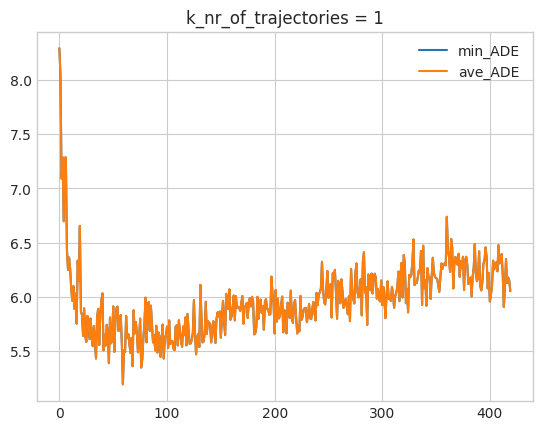

In [6]:
############## Calculate and plot one files

k_nr_of_trajectories = 1

sorted_predicted_probabilities, sorted_predicted_trajectories = get_sorted_most_likely_trajectories(logits_loaded_list[file_number], lattice)
min_ADE, ave_ADE = get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_loaded_list[file_number], k_nr_of_trajectories)

print(f"sorted_predicted_probabilities.shape = {sorted_predicted_probabilities.shape}")
print(f"sorted_predicted_trajectories.shape = {sorted_predicted_trajectories.shape}")
print(f"\nmin_ADE.shape = {min_ADE.shape}")
print(f"\nave_ADE.shape = {ave_ADE.shape}")
print(f"\nmin_ADE[-1] = {min_ADE[-1]}")
print(f"\nave_ADE[-1] = {ave_ADE[-1]}")

### One file ###
plt.plot(min_ADE, label="min_ADE")
plt.plot(ave_ADE, label="ave_ADE")
plt.legend();
plt.title(f"k_nr_of_trajectories = {k_nr_of_trajectories}");


predicted = 2
closest_lattice_index = 35
correct = False


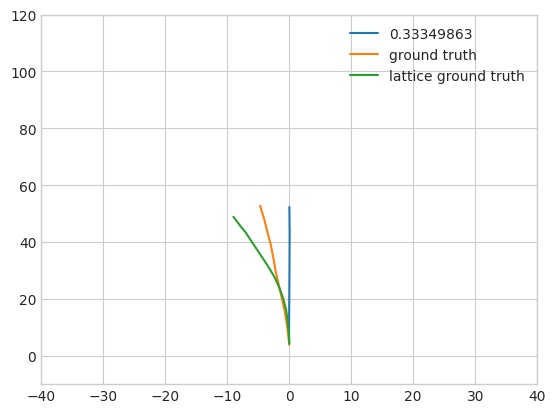

In [7]:
## Plot prediction vs ground truth

test_index = 163805

nrOfTopTrajectories = 1
ground_truth_trajectory = ground_truth_loaded_list[file_number][test_index]
probabilities = probabilities_list[file_number][test_index]
# print(f"ground_truth_trajectory.shape = {ground_truth_trajectory.shape}")
closest_lattice_index = mean_pointwise_l2_distance(torch.Tensor(lattice), torch.Tensor(ground_truth_trajectory))
topProbabilitiesIndices = np.argsort(probabilities)[::-1][0:nrOfTopTrajectories]
topProbabilities = [probabilities[index] for index in topProbabilitiesIndices]
# print(f"topProbabilitiesIndices = {topProbabilitiesIndices}")
# print(f"topProbabilities = {topProbabilities}")

# Lattice ground truth
predicted = topProbabilitiesIndices[0]
print(f"predicted = {predicted}")
print(f"closest_lattice_index = {closest_lattice_index}")
correct = (predicted == closest_lattice_index)
print(f"correct = {correct}")

# Plot predictions
[plt.plot(lattice[mode,:,0],lattice[mode,:,1], label=topProbabilities[i]) for i, mode in enumerate(topProbabilitiesIndices)]
# Plot ground truth
plt.plot(ground_truth_trajectory[:,0], ground_truth_trajectory[:,1], label="ground truth")
# Plot lattice ground truth
plt.plot(lattice[closest_lattice_index,:,0],lattice[closest_lattice_index,:,1], label="lattice ground truth")

plt.ylim([-10,120]); plt.xlim([-40,40]); plt.legend(); plt.show()




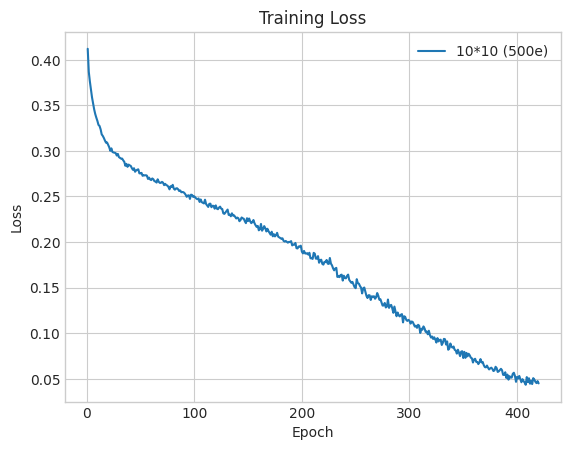

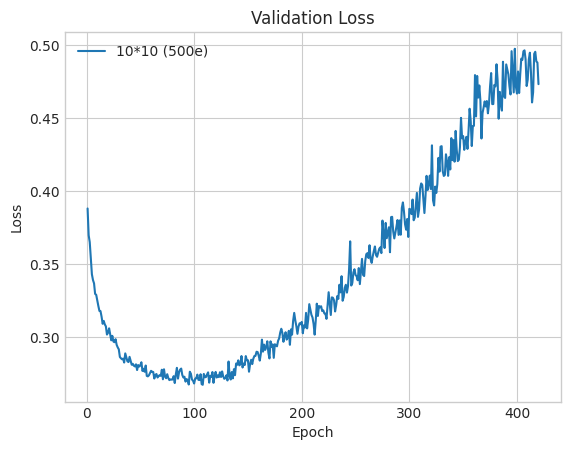

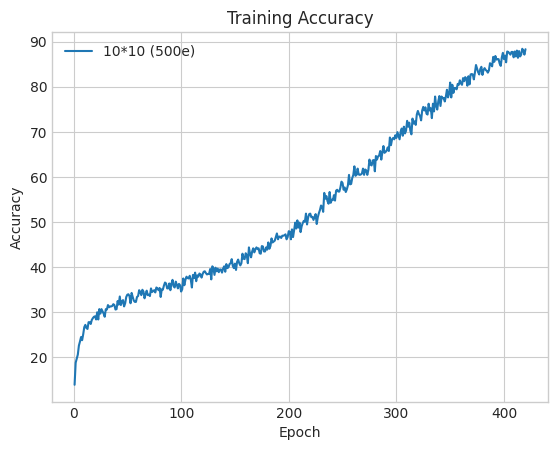

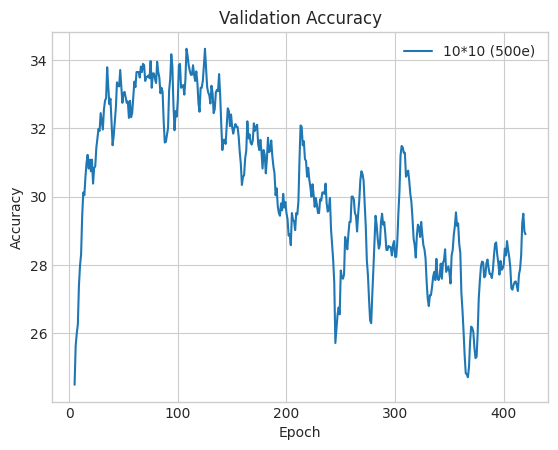

In [8]:
## Plot loss and accuracy

# File names
loss_acc_file_names = [f"{file_path}_loss_and_acc.txt" for file_path in file_path_list]

# Create empty arrays to store the data from text files
epochs = np.zeros((num_files, num_epochs))
train_loss = np.zeros((num_files, num_epochs))
val_loss = np.zeros((num_files, num_epochs))
train_acc = np.zeros((num_files, num_epochs))
val_acc = np.zeros((num_files, num_epochs))

# Loop over the text files
for i, filename in enumerate(loss_acc_file_names):
    with open(filename, 'r') as f:
        for j, line in enumerate(f):
            if j == num_epochs:
                break
            if line.startswith('Epoch'):
                parts = line.split(': ')
                epoch = int(parts[0].split('[')[1].split('/')[0])
                epochs[i][j] = epoch
                train_loss[i][j] = float(parts[2].split(' |')[0])
                val_loss[i][j] = float(parts[3].split(' |')[0])
                train_acc[i][j] = float(parts[4].split(' %')[0])
                val_acc[i][j] = float(parts[5].split(' %')[0])
if num_files > 4:
    val_loss[4,0] = val_loss[4,1]



# Training loss
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], train_loss[i], label=f'File {i+1}')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(legend_list)
plt.show()

# Validation loss
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], val_loss[i], label=f'File {i+1}')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(legend_list)
plt.show()

# Training accuracy
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], train_acc[i], label=f'File {i+1}')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(legend_list)
plt.show()

# Validation accuracy
plt.figure()
for i in range(num_files):
    # Convert the list to a pandas DataFrame
    df = pd.DataFrame(val_acc[i])
    # Apply a rolling window of size x and take the mean of each window
    smoothed = df.rolling(5).mean()
    # Convert the smoothed DataFrame back to a list
    smoothed_list = smoothed.values.tolist()
    numpy_smoothed_list = np.array(smoothed_list)
    squeezed_numpy_smoothed_list = np.squeeze(numpy_smoothed_list, 1)
    plt.plot(epochs[i], squeezed_numpy_smoothed_list, label=f'File {i+1}')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(legend_list)
plt.show()
